##### 搭配 OpenCV 實作電腦攝影機
這篇教學會將 PyQt5 結合 OpenCV 讀取攝影鏡頭的功能，實作一個能讀取電腦鏡頭的攝影機功能。

##### 所需技術 
要實作這個範例，必須要先具備基礎的 OpenCV 能力 ( 至少要安裝 OpenCV ) 以及了解什麼是 threading 多執行緒，可以透過下列文章了解相關知識：
* OpenCV 函式庫
* OpenCV 讀取並播放影片
* threading 多執行緒處理

##### 結合 OpenCV 讀取攝影機畫面 
載入對應的函式庫與模組，就能將 OpenCV 與 PyQt5 的程式整合，詳細解說在程式碼的註解中，下方列出一些重點：
* 因為 PyQt5 的視窗本身是「迴圈」，所以需要使用 threading 將 OpenCV 讀取影像的功能，放在另外的執行緒執行。
* OpenCV 讀取的影像色彩為 BGR，必須先轉換成 RGB，再使用 PyQt5 的 QImage 讀取，才能在視窗中正常顯示。

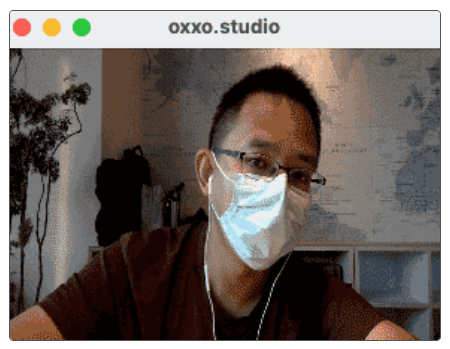

In [ ]:
from PyQt5 import QtWidgets
from PyQt5.QtGui import QImage, QPixmap
import sys, cv2, threading

app = QtWidgets.QApplication(sys.argv)

Form = QtWidgets.QWidget()
Form.setWindowTitle('oxxo.studio')
Form.resize(300, 200)

label = QtWidgets.QLabel(Form)     # 建立 QLabel
label.setGeometry(0,0,300,200)     # 設定 QLabel 大小和視窗相同

def opencv():
    cap = cv2.VideoCapture(0)      # 設定攝影機鏡頭
    if not cap.isOpened():
        print("Cannot open camera")
        exit()
    while True:
        ret, frame = cap.read()    # 讀取攝影機畫面
        if not ret:
            print("Cannot receive frame")
            break
        frame = cv2.resize(frame, (300, 200))   # 改變尺寸和視窗相同
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # 轉換成 RGB
        height, width, channel = frame.shape    # 讀取尺寸和 channel數量
        bytesPerline = channel * width          # 設定 bytesPerline ( 轉換使用 )
        # 轉換影像為 QImage，讓 PyQt5 可以讀取
        img = QImage(frame, width, height, bytesPerline, QImage.Format_RGB888)
        label.setPixmap(QPixmap.fromImage(img)) # QLabel 顯示影像

video = threading.Thread(target=opencv)
video.start()

Form.show()
sys.exit(app.exec_())

##### 影片適應視窗縮放 
如果要讓攝影機拍攝影片的尺寸可以隨著視窗縮放，就需要搭配視窗縮放的事件 ( 參考「視窗事件」 )，透過兩個全域變數紀錄視窗長寬，\
就能在改變視窗尺寸時，影片的尺寸也隨之變化。

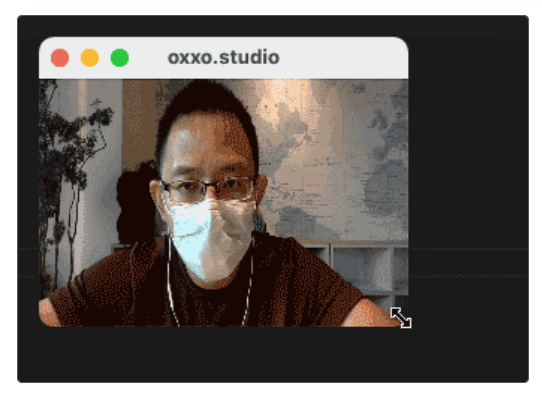

In [ ]:
from PyQt5 import QtWidgets
from PyQt5.QtGui import QImage, QPixmap
import sys, cv2, threading

app = QtWidgets.QApplication(sys.argv)
window_w, window_h = 300, 200    # 定義預設長寬尺寸

Form = QtWidgets.QWidget()
Form.setWindowTitle('oxxo.studio')
Form.resize(window_w, window_h)  # 使用變數

def windowResize(self):
    global window_w, window_h    # 定義使用全域變數
    window_w = Form.width()      # 讀取視窗寬度
    window_h = Form.height()     # 讀取視窗高度
    label.setGeometry(0,0,window_w,window_h)  # 設定 QLabel 長寬

Form.resizeEvent = windowResize  # 定義視窗尺寸改變時的要執行的函式

label = QtWidgets.QLabel(Form)
label.setGeometry(0,0,window_w,window_h)  # 使用變數

def opencv():
    global window_w, window_h    # 定義使用全域變數
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        exit()
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Cannot receive frame")
            break
        frame = cv2.resize(frame, (window_w, window_h))  # 使用變數
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        height, width, channel = frame.shape
        bytesPerline = channel * width
        img = QImage(frame, width, height, bytesPerline, QImage.Format_RGB888)
        label.setPixmap(QPixmap.fromImage(img))

video = threading.Thread(target=opencv)
video.start()

Form.show()
sys.exit(app.exec_())

##### 關閉視窗時，結束 OpenCV 程式 
實作過程中可能會發現，當視窗關閉時，OpenCV 的程式仍然會繼續運作 ( 因為兩個分處在不同的執行緒 )，如果要讓視窗關閉時也結束 OpenCV，\
就必須額外偵測視窗關閉事件，下方的程式執行後，當視窗關閉事件發生，會改變 ocv 全域變數的值，透過 ocv 全域變數，就能同時停止 OpenCV 程式的迴圈。

In [ ]:
from PyQt5 import QtWidgets
from PyQt5.QtGui import QImage, QPixmap
import sys, cv2, threading

app = QtWidgets.QApplication(sys.argv)
window_w, window_h = 300, 200

Form = QtWidgets.QWidget()
Form.setWindowTitle('oxxo.studio')
Form.resize(window_w, window_h)

def windowResize(self):
    global window_w, window_h
    window_w = Form.width()
    window_h = Form.height()
    label.setGeometry(0,0,window_w,window_h)

Form.resizeEvent = windowResize

ocv = True                     # 一開始設定為 True
def closeOpenCV(self):
    global ocv
    ocv = False                # 關閉視窗時設定為 False
Form.closeEvent = closeOpenCV  # 關閉視窗事件發生時，執行 closeOpenCV 函式

label = QtWidgets.QLabel(Form)
label.setGeometry(0,0,window_w,window_h)

def opencv():
    global window_w, window_h, ocv
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        exit()
    # while 迴圈改為 ocv
    while ocv:
        ret, frame = cap.read()
        if not ret:
            print("Cannot receive frame")
            break
        frame = cv2.resize(frame, (window_w, window_h))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        height, width, channel = frame.shape
        bytesPerline = channel * width
        img = QImage(frame, width, height, bytesPerline, QImage.Format_RGB888)
        label.setPixmap(QPixmap.fromImage(img))

video = threading.Thread(target=opencv)
video.start()

Form.show()
sys.exit(app.exec_())